In [36]:
import torch
import torch.nn as nn
import time
from tqdm import tqdm
from torchvision.transforms.functional import to_pil_image, to_tensor

# transforms 图像->tensor



In [37]:
from torchvision import transforms
# 128 x 3 x 64 x 64
size = 64

transform_image = transforms.Compose([
                                      transforms.RandomCrop(size),  # PIL Image
                                      transforms.ToTensor()  # Tensor
])

transform_test = transforms.Compose([
                                      transforms.ToTensor()  # Tensor
])

# prepare Dataset  
ImageFolder

In [38]:
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image

class ImageFolder(Dataset):
    def __init__(self, path):
        super(ImageFolder, self).__init__()
        self.path = os.path.abspath(path)
        self.image_list = os.listdir(self.path)  # List

    def __getitem__(self, item):
        image_path = self.image_list[item]
        image_path = os.path.join(self.path, image_path)
        image_pil = Image.open(image_path)
        return transform_image(image_pil) #返回的是剪切处理过的tensor torch.Size([3, 64, 64])

    def __len__(self):
        return len(self.image_list)


In [39]:
dataset = ImageFolder('./General-100')
loader = DataLoader(dataset, batch_size=20, shuffle=True, num_workers=0 )

# 加一个高斯噪声
std_gaus 标准差  
clamp 防止溢出 0-1

In [40]:
def add_noise(img_tensor, std_gaus):
    noise = torch.randn(img_tensor.shape).type_as(img_tensor) * std_gaus
    noised_img = img_tensor + noise
    return torch.clamp(noised_img, min=0., max=1.)

# CNNDenoiser

In [41]:
class CNNDenoiser(nn.Module):
    def __init__(self, num_channel=3, num_f=64):
        super(CNNDenoiser, self).__init__()
        # 20 x 3 x 64 x 64
        self.conv1 = nn.Conv2d(num_channel, num_f, 5, padding=2)
        # 20 x 64 x 64 x 64
        self.conv2 = nn.Conv2d(num_f, num_f, 3, padding=1)
        # 20 x 64 x 64 x 64
        self.conv3 = nn.Conv2d(num_f, num_f, 3, padding=1)
        # 20 x 64 x 64 x 64
        self.conv4 = nn.Conv2d(num_f, num_f, 3, padding=1)
        # 20 x 64 x 64 x 64
        self.conv5 = nn.Conv2d(num_f, num_channel, 5, padding=2)
        # 20 x 3 x 64 x 64

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = nn.functional.relu(self.conv5(x))
        return x


# 训练


In [42]:
num_epoches = 200
loss_func = nn.MSELoss()
model = CNNDenoiser() # Multiple Layer Perception
training_loader = loader

optimizer = torch.optim.Adam(model.parameters(), 0.001)

test_image = transform_test(Image.open('./General-100/im_16.bmp'))
transforms.functional.to_pil_image(test_image).save(f'./CONTENT/GT.png')  # Ground Truth
test_image_noised = add_noise(test_image, 0.1)
transforms.functional.to_pil_image(test_image_noised).save(f'./CONTENT/input.png')

In [43]:
#放在显卡上
model.cuda()
test_image_noised = test_image_noised.cuda()
loss_func.cuda()

for e in range(num_epoches):

    test_results = transforms.functional.to_pil_image(
        torch.clamp(model(test_image_noised.unsqueeze(0)).squeeze(0).cpu(), min=0., max=1.)
        )
    test_results.save(f'./CONTENT/{e}.png')

    losses = []
    start_time = time.time()
    for i, data_batch in enumerate(training_loader):
        data = data_batch.cuda()
        noised_data = add_noise(data, 0.1)
        denoised = model(noised_data)
        loss = loss_func(denoised, data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().item())
    end_time = time.time()
    print(f'{e + 1} epoch. Training Avg Loss {sum(losses) / len(training_loader):.4f}, time {end_time - start_time:.2f} s')
    torch.save(model.state_dict(), os.path.join('./SAVE_MODEL', 'epoch_{}.pth'.format(e)))

1 epoch. Training Avg Loss 0.1967, time 1.28 s
2 epoch. Training Avg Loss 0.0572, time 0.80 s
3 epoch. Training Avg Loss 0.0415, time 0.80 s
4 epoch. Training Avg Loss 0.0356, time 0.78 s
5 epoch. Training Avg Loss 0.0298, time 0.79 s
6 epoch. Training Avg Loss 0.0279, time 0.78 s
7 epoch. Training Avg Loss 0.0229, time 0.90 s
8 epoch. Training Avg Loss 0.0217, time 0.96 s
9 epoch. Training Avg Loss 0.0205, time 0.78 s
10 epoch. Training Avg Loss 0.0186, time 0.76 s
11 epoch. Training Avg Loss 0.0141, time 0.79 s
12 epoch. Training Avg Loss 0.0123, time 0.78 s
13 epoch. Training Avg Loss 0.0108, time 0.83 s
14 epoch. Training Avg Loss 0.0104, time 0.78 s
15 epoch. Training Avg Loss 0.0087, time 0.78 s
16 epoch. Training Avg Loss 0.0082, time 0.77 s
17 epoch. Training Avg Loss 0.0076, time 0.80 s
18 epoch. Training Avg Loss 0.0062, time 0.78 s
19 epoch. Training Avg Loss 0.0053, time 0.79 s
20 epoch. Training Avg Loss 0.0046, time 0.78 s
21 epoch. Training Avg Loss 0.0044, time 0.79 s
2

# tensor -> PIL image
`from torchvision.transforms.functional import to_pil_image, to_tensor`



In [44]:
len(dataset)


100

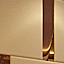

In [69]:
to_pil_image(dataset[21])


In [72]:
print(dataset[21].shape)

torch.Size([3, 64, 64])


In [73]:
dataset[21]


tensor([[[0.7922, 0.7922, 0.8275,  ..., 0.8157, 0.8157, 0.7922],
         [0.8000, 0.7843, 0.7961,  ..., 0.6510, 0.6392, 0.6196],
         [0.6667, 0.6667, 0.6431,  ..., 0.4863, 0.4941, 0.5137],
         ...,
         [0.6471, 0.6235, 0.6235,  ..., 0.7451, 0.7490, 0.7412],
         [0.6353, 0.6235, 0.6353,  ..., 0.7451, 0.7412, 0.7137],
         [0.6314, 0.6431, 0.6431,  ..., 0.7137, 0.7451, 0.7412]],

        [[0.6353, 0.6353, 0.6902,  ..., 0.6706, 0.6510, 0.6431],
         [0.6353, 0.6196, 0.6392,  ..., 0.4667, 0.4549, 0.4353],
         [0.4627, 0.4902, 0.4510,  ..., 0.2549, 0.2941, 0.2941],
         ...,
         [0.4745, 0.4314, 0.4627,  ..., 0.5922, 0.6078, 0.6078],
         [0.4627, 0.4392, 0.4706,  ..., 0.6000, 0.6039, 0.5843],
         [0.4706, 0.4706, 0.4706,  ..., 0.5647, 0.5922, 0.5843]],

        [[0.3451, 0.3451, 0.3647,  ..., 0.3804, 0.3804, 0.3804],
         [0.3137, 0.3098, 0.3137,  ..., 0.2471, 0.2392, 0.2392],
         [0.2314, 0.2353, 0.2314,  ..., 0.0392, 0.0824, 0.

In [76]:
img_tp=dataset[1]


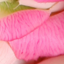

In [77]:
 to_pil_image(img_tp)

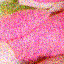

In [81]:
to_pil_image(add_noise(img_tp,0.1))  #添加噪声
